In [22]:
import pandas as pd
import numpy as np

from helper_functions import parse_html_file,read_filelist

import tldextract

import os 

import text_preprocessing as tp
from multiprocessing import Pool
import pickle

### Objective

The second task demands the classification of html provided into "News" and "Not News" categories. This can be treated as a binary classification problem. However, the definition of what constitutes 'News' is not clear from the problem definiion. From the Russian desciption of the problem, we can deduce that the objective is to remove irrelavant and encyclopeadic type references from the set of htmls provided.

### Scope
English and Russian htmls which were identified from the corpus (by Task1)

### What is News?
Some context in this link (https://apus.libanswers.com/faq/199127). But, mostly very generic. 

### Challenges
1. No labels are available for the htmls. Hence it's unclear what is 'News'
2. By visual observation, some of the articles might look like news for some (for eg. obituaries). It could be considered as news by some, and 'not news' by some other.
3. During manual exploration of the English articles, following potential 'non-news' cases were observed
    - Title and image only files (cartoons, Instagram-type posts)
    - Horoscops, obituaries (articles that might appear in a newspaper, but not really news)
    - Press releases or webpage type content from websites

### Solution appraoch
Idea 1 : 
1. Tag a large majority of the articles manually (possibly with the help of Amazon Mechanical Turk or CrowdFlower type services. This is a costly and time consuming approach, but assured to make the problem superficial and bring out the human intelligence into the problem (As humans are really good at classifying something as news once they see)

2. Prepare the following set of features from the articles
    - Embedded representation of the html text
    - Structural features (ratio of text to embedded links (href)
    - Time and Date features
    - URL/Source features
3. Prepare a classifier to separate two classes based on the semantic differences between news and not news (if any)


Idea 2 : 
1. Cluster the news articles based on their structural features : Length of text, number of links etc.
2. Inspect the cluster and label the cluster.
2. Prepare the following set of features from the articles
    - Embedded representation of the html text
    - Structural features (ratio of text to embedded links (href)
    - Time and Date features
    - URL/Source features
3. Prepare a classifier to separate two classes based on the semantic differences between news and not news (if any)
    
Idea 3 : 
1. Remove the articles with extremely short amount of text
2. Remove the articles that has certain pre-defined list of words in title (Recipe, Horoscope, Review)

Idea 4 : 
1. Prepare a list of pre-defined news sources

# Useful functions

In [2]:
# Create features from the domain
def get_domain_features(d):
    ext = tldextract.extract(d['url'])
    domain = ext.domain
    
    return domain

In [3]:
# List a set of newsy_words

# This list can be further expanded by adding top unique words
# found across news articles

newsy_words = ['news','daily','desk','breaking','archive','times','report','network']
non_newsy_words = ['recipe','horoscope','lottery','advertisement','ad']

In [27]:
# # Pickle to load this from memory
# with open("assets/newsy_words.pickle","wb") as p:
#     pickle.dump(newsy_words, p)
    
# # Pickle to load this from memory
# with open("assets/non_newsy_words.pickle","wb") as p:
#     pickle.dump(non_newsy_words, p)

In [40]:
def extract_features(html,newsy_words,non_newsy_words,**kwargs):
    '''
    Looks up newsy and no-newsy keywords from the list.
    Return the total word count and newsy counts
    Provide the argument section to extract features corresponding
    to that section. If no section is provided, all_text is used'''
    try:
        section = kwargs['section']
    except KeyError as e:
        section = 'all_text'
   
    if section == 'url':
        import re
        
        news_ctr = 0
        no_news_ctr = 0
        for x in newsy_words:
            regx = re.compile(f'[^a-z]{x}[^a-z]|^{x}[^a-z]|[^a-z]{x}$')
            if regx.search(html['url']):
                news_ctr+=1
        for x in non_newsy_words:
            regx = re.compile(f'[^a-z]{x}[^a-z]|^{x}[^a-z]|[^a-z]{x}$')
            if regx.search(html['url']):
                no_news_ctr+=1     
        r_d = {section+'_num_nw': news_ctr,
               section+'_num_no_nw': no_news_ctr
              }
        return r_d
    # If not url, pre-process text and contnue
    try:
        text = tp.preprocess(html[section])
    except Exception as e:
        print(e)
        text = ""
    
    nw = set(text).intersection(newsy_words)
    no_nw = set(text).intersection(non_newsy_words)   
    
    r_d = {section+'_num_nw':len(nw),
           section+'_num_no_nw':len(no_nw),
           section+'_tot_words' : len(text)
          }
    
    try:
        if kwargs['return_text']:
            r_d[section+'_tokens'] = text
    except KeyError as e:
        pass
    
    return r_d

In [41]:
def create_domain_feats(html,domain_rank_list):
    # 難しい
    # Later, embeddings for each source could be prepared
    # When new domains are identified, update the embedding
    return 0    

In [42]:
def aggregate_features(fname):
    #Pickle newsy_words
    with open("assets/newsy_words.pickle","rb") as p:
        newsy_words = pickle.load(p)
    with open("assets/non_newsy_words.pickle","wb") as p:
        pickle.dump(non_newsy_words, p)
    #Pickle read any domain_features
    html = parse_html_file(fname)
    s = {}

    s.update(extract_features(html,newsy_words,non_newsy_words,section='url'))
    s.update(extract_features(html,newsy_words,non_newsy_words,section='site_name'))
    s.update(extract_features(html,newsy_words,non_newsy_words,section='title'))
    s.update(extract_features(html,newsy_words,non_newsy_words,section='all_text',return_text=True))
    
      # Number of links in the article
    s['num_links'] = len(html['links'])
    
    return s

# Idea 1:

Tagging the articles manually is timne consuming and costly. Skipping

# Idea 2:

### Identify 'newsy keywords' from large news corpora

In [43]:
# Test
aggregate_features('en/993065158717575.html')

{'url_num_nw': 2,
 'url_num_no_nw': 0,
 'site_name_num_nw': 1,
 'site_name_num_no_nw': 0,
 'site_name_tot_words': 2,
 'title_num_nw': 0,
 'title_num_no_nw': 0,
 'title_tot_words': 9,
 'all_text_num_nw': 1,
 'all_text_num_no_nw': 0,
 'all_text_tot_words': 132,
 'all_text_tokens': ['watch',
  'light',
  'left',
  'dangling',
  'roof',
  'goalkeeper',
  'blasts',
  'penalty',
  'stands',
  'eyebrows',
  'raised',
  'goalkeeper',
  'tony',
  'breeden',
  'stepped',
  'take',
  'penalty',
  'nuneaton',
  'borough',
  'like',
  'ball',
  'struck',
  'continued',
  'rise',
  'afterwards',
  'looking',
  'break',
  'deadlock',
  'nonleague',
  'side',
  '61st',
  'minute',
  'breeden',
  'blasted',
  'spot',
  'kick',
  'bar',
  'straight',
  'light',
  'stands',
  'luke',
  'dillam',
  'seventeen',
  'filmed',
  'moment',
  'told',
  'pa',
  'news',
  'agency',
  'penalty',
  'given',
  'thought',
  'okay',
  'break',
  'deadlock',
  'goal',
  'goalie',
  'takes',
  'ball',
  'striker',
  'pl

### Compute the above features for a subset of files in which have been identified as English

In [44]:
file_list = read_filelist('en/')

2019-11-30 18:06:29,255 - INFO - Defaulting to 'htm*'


In [45]:
# Take a small sample for testing
import random
f = random.sample(file_list, 1000)

In [48]:
%%time
with Pool(8) as pool:
        results = pool.map(aggregate_features,f)

CPU times: user 84.2 ms, sys: 76.4 ms, total: 161 ms
Wall time: 17.3 s


In [14]:
# Convert to dataframe and create summed up features

n_feats = pd.DataFrame(results)

n_feats['fname'] = f
n_feats['news_keys'] = n_feats['title_num_nw'] + n_feats['site_name_num_nw'] + n_feats['url_num_nw']
n_feats['not_news_keys'] = n_feats['title_num_no_nw'] + n_feats['site_name_num_no_nw'] + n_feats['url_num_no_nw']


2019-11-30 16:39:21,987 - INFO - NumExpr defaulting to 8 threads.


In [28]:
full_path = False
if full_path:
    news_articles = list(n_feats[n_feats['not_news_keys'] < n_feats['news_keys']].fname)
else:
    news_articles = list(n_feats[n_feats['not_news_keys'] < n_feats['news_keys']].fname.map(os.path.basename))

In [29]:
news_articles

['4625792331778747793.html',
 '4945708899359605132.html',
 '675785260679529812.html',
 '302165936071781337.html',
 '7786541636297243782.html',
 '7750663361336497245.html',
 '4566489171919576902.html',
 '4882419918441742364.html',
 '6679535024409725243.html',
 '2239022090336426082.html',
 '675785260991595564.html',
 '7605153804790694456.html',
 '1887544296045690007.html',
 '5246707018196683640.html',
 '830332543119986056.html',
 '4778851489686527309.html',
 '1984146902370834817.html',
 '7786541637804463228.html',
 '7605153804504333860.html',
 '121801344560752042.html',
 '8612811651381700135.html',
 '6679535026197494323.html',
 '5327740410713862156.html',
 '1253419763541649278.html',
 '7362823821617285807.html',
 '9121942837873552032.html',
 '8912634263112072361.html',
 '1603024965402305642.html',
 '675785260520489908.html',
 '4415806919648858890.html',
 '8668874340179502615.html',
 '6395891953402457433.html',
 '3752801376747820187.html',
 '6395891952637209204.html',
 '772721117396150745

### Apply KMeans with this limited features

In [93]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
y = kmeans.fit_predict(n_feats[['title_len','text_len','count_links','len_nw']])

n_feats['cls'] = y

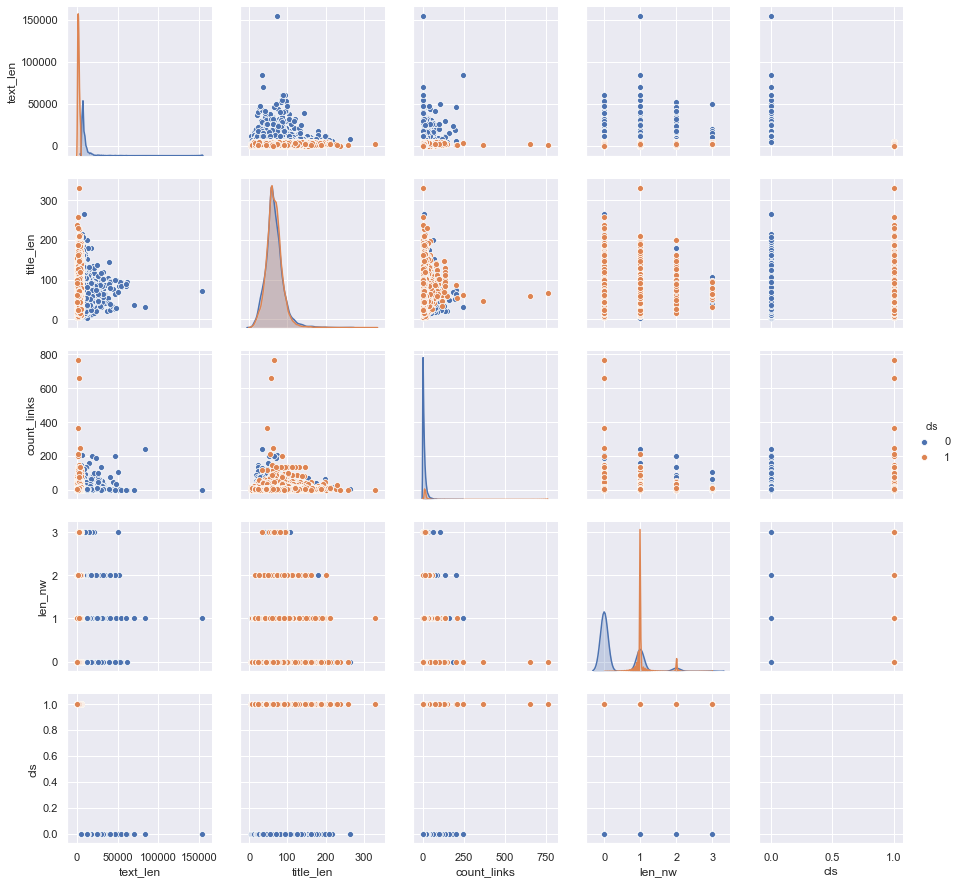

In [76]:
import seaborn as sns;
sns.set()
import matplotlib.pyplot as plt
ax = sns.pairplot(hue='cls',data=n_feats)

#### Class 0 seem to be the more non-informative class. Move them to a folder for inspection

In [82]:
c0 = n_feats[n_feats['cls']==0].fname
c1 = n_feats[n_feats['cls']==1].fname


In [86]:
from shutil import copyfile

os.mkdir('cls1')

for f in c1:
    copyfile(f,'cls1/'+os.path.basename(f))

#### Inspected results

Checked the files in the folders. News and non-news articles are highly overlapped.
This set of features are not good enough to segregate these articles.

# Idea 4:

#### Rule based separation of the articles

For each article, check if it has some non news keywords and then drop them

In [ ]:
check_keywords(html,non_newsy_words,section='title')

In [146]:
html = parse_html_file('en/993065158717575.html')

In [147]:
check_keywords(html,newsy_words,non_newsy_words,section='title')

set()


{'len_nw': 0, 'sum_new': 0, 'len_no_nw': 0, 'sum_no_nw': 0}

In [128]:
html

{'title': 'Watch: Light left dangling from roof after goalkeeper blasts penalty into stands',
 'url': 'http://www.irishnews.com/magazine/daily/2019/11/16/news/watch-light-left-dangling-from-roof-after-goalkeeper-blasts-penalty-into-stands-1767455/',
 'site_name': 'The Irish News',
 'published_time': '2019-11-16T20:20:00+00:00',
 'description': 'Watch: Light left dangling from roof after goalkeeper blasts penalty into stands',
 'p_text': ' Eyebrows were raised when goalkeeper Tony Breeden stepped up to take a penalty for Nuneaton Borough and – like the ball he struck – they continued to rise afterwards. Looking to break the deadlock for the non-league side in the 61st minute, Breeden blasted the spot kick over the bar and straight into a light in the stands. Luke Dillam, 17, filmed the moment and told the PA news agency: “The penalty was given, I thought okay we can break the deadlock here with this goal, but then the goalie takes the ball off the striker and places it down. “He skies i

In [130]:
try:
    section = 'title'
except KeyError as e:
    section = 'all_text'

try:
    text = tp.preprocess(html[section])
except Exception as e:
    print(e)
    text = ""

nw = set(text).intersection(newsy_words)
no_nw = set(text).intersection(non_newsy_words)                 

r_d = {'len_nw': len(nw),
       'sum_new': sum(nw),
       'len_no_nw': len(no_nw),
       'sum_no_nw': sum(no_nw)
      }             

In [132]:
nw = set(text).intersection(newsy_words)

In [134]:
no_nw = set(text).intersection(non_newsy_words)   

In [139]:
sum(no_nw)

0

In [143]:
r_d = {'len_nw': len(nw),
       'sum_new': sum(nw),
       'len_no_nw': len(no_nw),
       'sum_no_nw': sum(no_nw)
      }   

In [141]:
r_d

{'len_nw': 0, 'sum_new': 0, 'len_no_nw': 0, 'sum_no_nw': 0}